In [53]:
#Setup
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from audl_elo import generate

#g = pd.read_csv("audl_elo.csv") #  is short for games table
g = generate(K=20)
g['year_id'] = g['year_id'].astype(int)
nba_g = pd.read_csv("nbaallelo.csv") #dataset from fivethirtyeight
g.tail()

12 12
17 17
25 25
26 26
24 24
23 23
21 21


,gameorder,game_id,_iscopy,year_id,date,seasongame,is_playoffs,team_id,fran_id,pts,elo_i,elo_n,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast
2111,1056,201905050DET,1,2019,05/05/2019,4,0,MIN,Windchill,31,1524.111385,1536.817115,DET,Mechanix,22,1308.675166,1295.969435,A,W,0.705107
2112,1057,201905050RAL,0,2019,05/05/2019,5,0,RAL,Flyers,23,1633.164106,1639.571458,AUS,Sol,18,1454.712707,1448.305355,H,W,0.801495
2113,1057,201905050RAL,1,2019,05/05/2019,5,0,AUS,Sol,18,1454.712707,1448.305355,RAL,Flyers,23,1633.164106,1639.571458,A,L,0.198505
2114,1058,201905050PHI,0,2019,05/05/2019,3,0,PHI,Phoenix,21,1413.373088,1427.486584,OTT,Outlaws,16,1411.063823,1396.950327,H,W,0.594285
2115,1058,201905050PHI,1,2019,05/05/2019,3,0,OTT,Outlaws,16,1411.063823,1396.950327,PHI,Phoenix,21,1413.373088,1427.486584,A,L,0.405715


## Looking at Regular Season Win Percentage Distribution

I split the games by team and season to get season win percentages for each team, then plot these to see the distribution.

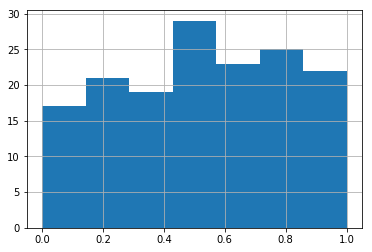

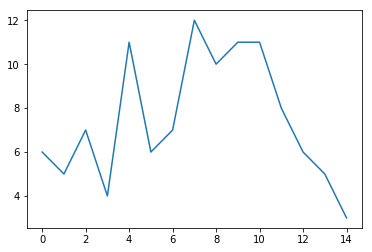

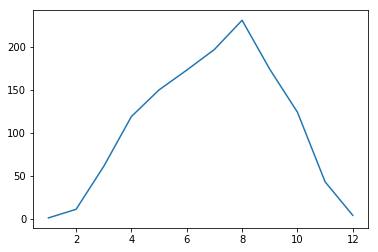

In [9]:
def calc_win_percentage(column):    
    counts = column.value_counts()
    if 'W' in counts:
        win_percentage = counts['W']/len(column)
    else:
        win_percentage = 0
    return win_percentage

def calc_num_wins(column):
    counts = column.value_counts()
    if 'W' in counts:
        wins = counts['W']
    else:
        wins = 0        
    return wins

def calc_num_wins_round(column):
    counts = column.value_counts()
    if 'W' in counts:
        win_percentage = counts['W']/len(column)
    else:
        win_percentage = 0
    wins = round(win_percentage * 14)
    return int(wins)

def plot_win_percentage_histogram(elo_table = g,years_list = [],bins_=10):
    split = elo_table[elo_table['is_playoffs'] == 0].groupby(['year_id','fran_id'])

    win_percentages = split["game_result"].agg(calc_win_percentage)
    if years_list:
        t = win_percentages.loc[years_list]
    else:
        t = win_percentages
    t.hist(bins=bins_)
    plt.show()
    
def plot_number_of_wins(elo_table = g, years_list = []):
    split = elo_table[elo_table['is_playoffs'] == 0].groupby(['year_id','fran_id'])

    wins = split["game_result"].agg(calc_num_wins_round)
    if years_list:
        t = wins.loc[years_list]
    else:
        t = wins
    
    t.value_counts(sort = False).plot()
    plt.show()
    
    
plot_win_percentage_histogram(bins_=7)
plot_number_of_wins(years_list = range(2012,2018))
plot_number_of_wins(nba_g,years_list = range(1968,2016))

## Predictive Ability of Current Elo Algorithm

The predictive ability seems to be off a bit as we can see by these numbers.

C:\Users\crsmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\crsmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


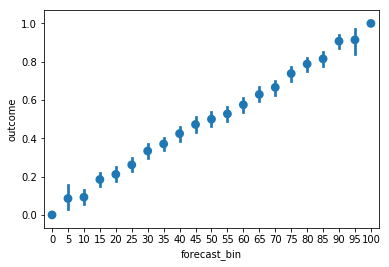

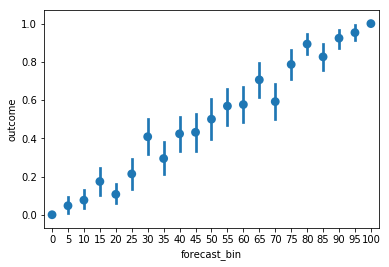

In [51]:
def create_win_percentage_brackets(elo_table=g,year_list=[],bins=20):
    ranges = bins
    desired_win_percentages = []
    actual_win_percentages = []
    for i in range(ranges+1):
        low = i/ranges - .5/ranges
        high = (i+1)/ranges - .5/ranges
        if year_list:
            years_g = elo_table[elo_table['year_id'].isin(year_list)]
        else:
            years_g = elo_table
        target_games = years_g[(years_g['forecast'] <= high) & (years_g['forecast'] > low)]
        target_counts = target_games['game_result'].value_counts()
        if 'W' in target_counts:
            win_percent = target_counts['W']/len(target_games)
        elif 'L' in target_counts:
            win_percent = 0
        else:
            win_percent = i/ranges+.5/ranges
        desired_win_percentages.append(i/ranges)
        actual_win_percentages.append(win_percent)
        #print(str(100*i/ranges),"% Bracket : ", win_percent, "     Count:",len(target_games))
    return actual_win_percentages,desired_win_percentages,pd.Series(actual_win_percentages,desired_win_percentages)
        
def plot_win_percentage_brackets(elo_table=g,year_list=[],bins=20):
    actual_win_percentages,desired_win_percentages,_ = create_win_percentage_brackets(elo_table,year_list,bins)
    #print(actual_win_percentages,desired_win_percentages,_)
    plt.plot(desired_win_percentages,actual_win_percentages)
    plt.plot(desired_win_percentages,desired_win_percentages)
    plt.show()
    
import seaborn as sns
import numpy as np

def calibration_plot(table=g,year_list=[],bins=20):
    elo_table = table.loc[table['year_id'].isin(year_list)]
    outcome_map = {'W':1,"L":0}
    elo_table['outcome'] = elo_table['game_result'].map(outcome_map)
    bin_edges = np.linspace(-.5/bins,1+.5/bins,bins+2)
    bin_labels = np.linspace(0,100,bins+1).astype(int)
    elo_table['forecast_bin'] = pd.cut(elo_table['forecast'],bins=bin_edges,labels=bin_labels)
    #print(elo_table.tail())
    #print(elo_table[elo_table['forecast_bin'] == 100])
    ax = sns.pointplot(x='forecast_bin',y='outcome',data=elo_table,join=False,ci=95)
    plt.show()
    
    
#plot_win_percentage_brackets(nba_g)
#plot_win_percentage_brackets(g,bins=20,year_list = range(2012,2019))

calibration_plot(nba_g,year_list = range(2012,2020))
calibration_plot(g,bins=20,year_list = range(2012,2020))


## Analysis 

The last two sections seem to indicate that our current model doesn't have great predictive value of the outcome of games. The second graph shows that good teams are better (win more often) than our model predicts and bad teams are worse (lose more often) than our model predicts. 

We can see from the first graph that, if we use the regular season win percentage as a proxy for how good a team is, teams in the AUDL may not be distributed normally (actually logistically) distributed in skill as would be needed for the current Elo Algorithm to work. However, there may be other problems we should rule out first.
1. Our numbers are wrong
    1. The k value (20) is wrong.
    2. Our update function based on margin of victory and point differential is wrong.
    3. Our Year-to-Year elo point carryover is wrong (currently 2/3 of previous years elo).
2. There isn't enough data - the league hasn't played enough games yet.
3. The talent of teams is not distributed normally.

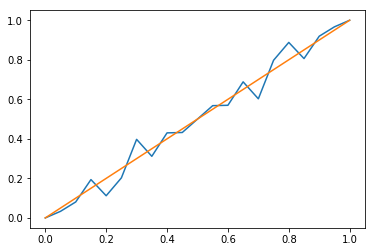

In [52]:
plot_win_percentage_brackets(g,year_list=[2014,2015,2016,2017,2018],bins=20)

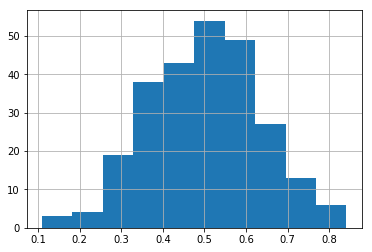

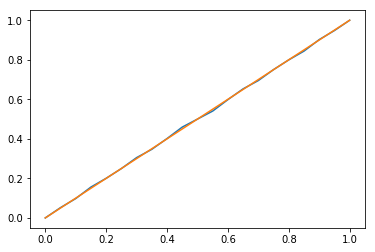

In [49]:
## Comparison with NBA
nba_g = pd.read_csv("nbaallelo.csv") #dataset from fivethirtyeight

plot_win_percentage_histogram(nba_g,range(1970,1980),bins_=10)
plot_win_percentage_brackets(nba_g)

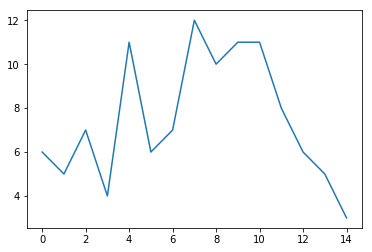

In [35]:
elo_table = g.copy()
years_list = [2012,2013,2014,2015,2016,2017]
bins_=10

split = elo_table[elo_table['is_playoffs'] == 0].groupby(['year_id','fran_id'])

wins = split["game_result"].agg(calc_num_wins_round)
if years_list:
    t = wins.loc[years_list]
else:
    t = wins

t.value_counts(sort = False).plot()

In [57]:
## Compare with NFL (new file formal for this)
ng = pd.read_csv('rating/data/test_audl_elo.csv')
nfl_g = pd.read_csv('nfl_elo.csv')

#ng['game_result'] = ['W' if ng['score1'] > ng['score2']]

print(ng.tail())
g.tail()


            date  season  neutral  playoff team1 team2     elo1_pre  \
1016  07/28/2018    2018        0        1   TOR    NY  1738.434075   
1017  07/28/2018    2018        0        1   DAL   RAL  1716.503175   
1018  08/11/2018    2018        1        1   DAL    NY  1720.814764   
1019  08/11/2018    2018        0        1   MAD    LA  1719.538263   
1020  08/12/2018    2018        0        1   MAD   DAL  1729.763800   

         elo2_pre  elo_prob1  elo_prob2    elo1_post    elo2_post  score1  \
1016  1565.334120   0.796548   0.203452  1726.057744  1577.710450      17   
1017  1656.351483   0.671433   0.328567  1720.814764  1652.039895      20   
1018  1577.710450   0.695037   0.304963  1727.106241  1571.418972      32   
1019  1639.653444   0.695988   0.304012  1729.763800  1629.427907      24   
1020  1727.106241   0.594768   0.405232  1742.424121  1714.445921      20   

      score2  
1016      18  
1017      19  
1018      30  
1019      19  
1020      16  


,gameorder,game_id,_iscopy,year_id,date,seasongame,is_playoffs,team_id,fran_id,pts,elo_i,elo_n,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast
2059,1030,201904130SDX,1,2019,04/13/2019,3,0,SJ,Spiders,24,1490.146975,1485.462719,SD,Growlers,25,1530.675069,1535.359325,A,L,0.353952
2060,1031,201904130ATL,0,2019,04/13/2019,2,0,ATL,Hustle,21,1495.374322,1483.655205,RAL,Flyers,24,1607.036956,1618.756072,H,L,0.431835
2061,1031,201904130ATL,1,2019,04/13/2019,3,0,RAL,Flyers,24,1607.036956,1618.756072,ATL,Hustle,21,1495.374322,1483.655205,A,W,0.568165
2062,1032,201904140IND,0,2019,04/14/2019,1,0,IND,Alleycats,20,1572.324159,1562.252222,MAD,Radicals,22,1661.617719,1671.689657,H,L,0.463664
2063,1032,201904140IND,1,2019,04/14/2019,1,0,MAD,Radicals,22,1661.617719,1671.689657,IND,Alleycats,20,1572.324159,1562.252222,A,W,0.536336


['Radicals', 'Mechanix', 'Thunderbirds', 'Wildfire']

Rampage 2012
17 [2012, 2012.0555555555557, 2012.111111111111, 2012.1190476190477, 2012.1666666666667, 2012.2222222222222, 2012.2777777777778, 2012.3333333333333, 2012.3412698412699, 2012.388888888889, 2012.5, 2012.611111111111, 2012.6666666666667, 2012.6746031746031, 2012.7777777777778, 2012.8333333333333, 2012.9444444444443]
17 [1500.0, 1417.075037328587, 1492.9135391297234, 1536.6354899057435, 1466.6242743192522, 1480.2643541512136, 1448.5883277673727, 1435.9333019718238, 1471.0764060484628, 1492.500234824179, 1471.906547286092, 1453.133112743928, 1477.2105282727914, 1347.9123461406414, 1406.8996812896648, 1400.1378010841624, 1384.8248689152265]

Constitution 2012
17 [2012, 2012.0555555555557, 2012.111111111111, 2012.2222222222222, 2012.2777777777778, 2012.3333333333333, 2012.388888888889, 2012.4444444444443, 2012.5, 2012.5555555555557, 2012.611111111111, 2012.6190476190477, 2012.6666666666667, 2012.7222222222222, 2012.73015873015

AttributeError: 'AxesSubplot' object has no attribute 'get_ytikcs'

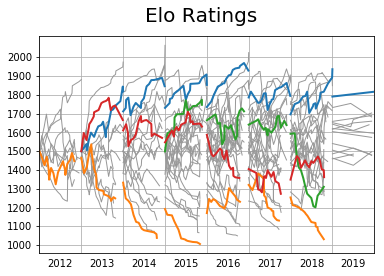

In [115]:
from importlib import reload
import tools
reload(tools)
tools.one_plot(['MAD','DET','PIT','CHI'],elo_dataframe=g)

In [4]:
import seaborn as sns

tips = sns.load_dataset("tips")

In [ ]:
g.head()